In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

import statistics
import math
import ndoc_util
import matplotlib.pyplot as plt
import random
from pyarrow import parquet as pq
import pyarrow as pa

import random

DATA_LENGTH_UNIT = 60
DATA_LENGTH = DATA_LENGTH_UNIT*5+20

def _down_sampling(a):
    
    a = np.array(a)
    import copy
    if(len(a)%2==1): a = np.append(a,0)
    c = copy.copy(a)
    c = np.array(c)
    ret =c.reshape(-1, 2).mean(axis=1)
 
    return ret  

def down_sampling(a,digree):
    
    for i in range(digree):
        a = _down_sampling(a)
    
    return a


def modify_signal(signal):

    modification_count = len(signal) * 0.5
    modification_count = int(round(modification_count / 2)) * 2
    modification_positions = random.sample(range(len(signal)), k=modification_count)
    half = int(modification_count / 2)
    duplication_positions = set(modification_positions[:half])
    deletion_positions = set(modification_positions[half:])

    new_signal = np.empty([len(signal)], dtype=float)
    j = 0
    for i, val in enumerate(signal):
        if i in duplication_positions:
            new_signal[j] = val
            j += 1
            new_signal[j] = val
            j += 1
        elif i in deletion_positions:
            pass
        else:
            new_signal[j] = val
            j += 1

    assert j == len(signal)
    return new_signal  


def addbias(sglist):
    
    
    a = np.random.normal() * 0.05
    b = np.random.normal()
    newlist = []
    cnt = 0
    for n in sglist:
        
        n = n + (a*cnt) + b 
        newlist.append(n)
        cnt = cnt +1
        
    return newlist
    

def argument(row):
    
    #argument binlength
    binlength = row[1]
    s = np.random.normal(0, 3, 5)

    binlength = binlength +s
    binlength = np.clip(binlength, 1, 120)
    
    signal = list(row[0])
    
    sglst = []
    #argument 
    for n in range(5):
        
        sg = signal[DATA_LENGTH_UNIT*n:DATA_LENGTH_UNIT*(n+1)]
        ms = modify_signal(sg)
        sglst.extend(ms)
    
    signal = ndoc_util.zeropadding10(sglst)
    signal = np.array(signal)
    signal = np.clip(signal,1,254)
    signal = signal.astype('float32')/255.  
    originalsize = ndoc_util.extendAry(binlength)        
    originalsize = ndoc_util.zeropadding10(originalsize)
        
    
    return signal,originalsize


def liniarBias(row):

    binlength = row[1]
    s = np.random.normal(0, 3, 5)

    binlength = binlength +s
    binlength = np.clip(binlength, 1, 120)
    
    signal = list(row[0])
    signal = addbias(signal)     
    
    signal = ndoc_util.zeropadding10(signal)
    signal = np.array(signal)
    signal = np.clip(signal,1,254)
    signal = signal.astype('float32')/255.  
    originalsize = ndoc_util.extendAry(binlength)        
    originalsize = ndoc_util.zeropadding10(originalsize)
        
    
    return signal,originalsize
    
    
def noiseBias(row):

    binlength = row[1]
    s = np.random.normal(0, 3, 5)

    binlength = binlength +s
    binlength = np.clip(binlength, 1, 120)
    
    signal = list(row[0])
    signal = np.array(signal)
    signal = ndoc_util.addnoise(signal)     
    
    signal = ndoc_util.zeropadding10(signal)
    
    signal = np.clip(signal,1,254)
    signal = signal.astype('float32')/255.  
    originalsize = ndoc_util.extendAry(binlength)        
    originalsize = ndoc_util.zeropadding10(originalsize)
        
    
    return signal,originalsize    
    

def downSamplingBias(row):

    binlength = row[1]
    s = np.random.normal(0, 3, 5)

    binlength = binlength +s
    binlength = np.clip(binlength, 1, 120)
    
    signal = list(row[0])
    s = pd.Series(signal)
    signal = s.rolling(window=4).mean().to_numpy()
    
    signal = np.nan_to_num(signal)
    
    signal = ndoc_util.zeropadding10(signal)
    signal = np.array(signal)
    signal = np.clip(signal,1,254)
    signal = signal.astype('float32')/255.  
    originalsize = ndoc_util.extendAry(binlength)        
    originalsize = ndoc_util.zeropadding10(originalsize)
        
    
    return signal,originalsize    
    
    
    
def notFlat(data):
    
   
    import ruptures as rpt
    # generate signal
    n_samples, dim, sigma = 1000, 3, 4
    n_bkps = 4  # number of breakpoints
    sg, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)
    data = down_sampling(data,2)
    algo = rpt.Pelt(model="rbf").fit(data)
    result = algo.predict(pen=4)    
    l = len(result)    
    
#     print(l)
#     plt.plot(data)
#     plt.show()
    return l > 1  

def filterFlat(datas,uplimit2):
    
    ret = []
    cnt = 0
    for d in datas:

        if notFlat(list(d[0])):
            ret.append(d)
            cnt = cnt +1    
        if cnt >=  uplimit2:
            break
        
    return ret

def formatD(datas):
    
    refdatas = []
    
    cnt = 1
    for row in datas:

        cnt = cnt+1
        signal = np.array(list(row[0])) 
        if cnt == 2:
            print("signal",signal[0])
        signal = ndoc_util.zeropadding10(signal)
        signal = np.array(signal)
        signal = signal.astype('float32')/255.  
        originalsize = ndoc_util.extendAry(row[1])        
        originalsize = ndoc_util.zeropadding10(originalsize)
        
        refdatas.extend(signal)
        refdatas.extend(originalsize)
            
     
    
        
#         if cnt<=2:
            
#             plt.plot(signal)
#             plt.show()
#             plt.plot(originalsize)
#             plt.show()
    
#             plt.plot(asignal)
#             plt.show()
#             plt.plot(aoriginalsize)
#             plt.show()
            
#             plt.plot(asignal2)
#             plt.show()
#             plt.plot(aoriginalsize2)
#             plt.show()
            
#             plt.plot(asignal3)
#             plt.show()
#             plt.plot(aoriginalsize3)
#             plt.show()
            
#             plt.plot(asignal4)
#             plt.show()
#             plt.plot(aoriginalsize4)
#             plt.show()

    return refdatas

    
    
    
refpqSC = "/groups2/gac50430/nanopore/equalbinnedpq/cerrRnaIvt"
targetpqSC = "/groups2/gac50430/nanopore/equalbinnedpq/cerrRnaNative"
minreadlen = 500
refprSC = ndoc_util.PqReader(refpqSC,minreadlen)
targetprSC = ndoc_util.PqReader(targetpqSC,minreadlen) 

refpqEC = "/groups2/gac50430/nanopore/equalbinnedpq/ecrRnaIvt"
targetpqEC = "/groups2/gac50430/nanopore/equalbinnedpq/ecrRnaNative"

refprEC = ndoc_util.PqReader(refpqEC,minreadlen)
targetprEC = ndoc_util.PqReader(targetpqEC,minreadlen) 

uplimit = 6000
uplimit2 = 3000

#make parquet file for clustering
modf = "/groups2/gac50430/nanopore/shell/nanoIICTest/multipleMod5mer.txt"
dfmod = pd.read_csv(modf, sep='\t')

for fmer in dfmod["fmer"].unique():
    
    dfq = dfmod.query('fmer == "' + fmer+'"')
    fout = "/groups2/gac50430/nanopore/shell/nanoIICTest/"+fmer+"_org.pq"
    
    
    resultdata = []
    cnt = 0
    for tp in dfq.itertuples():
        
        cnt = cnt +1
            
        fmer = tp[1]
        mod = tp[2]
        ref = tp[3]
        chrom = tp[4]
        pos = tp[5]
        strand = tp[6]
        print((fmer,mod,ref,chrom,pos,strand))
        
        if ref =="16S" or  ref =="23S":
            
            rawdatas,cnt =  targetprEC.getData(chrom,strand,pos,uplimit)        
            refdatas,cntref = refprEC.getData(chrom,strand,pos,uplimit)
            
        else:
            
            rawdatas,cnt =  targetprSC.getData(chrom,strand,pos,uplimit)        
            refdatas,cntref = refprSC.getData(chrom,strand,pos,uplimit) 
        
        rawdatas = filterFlat(rawdatas,uplimit2) 
        refdatas = filterFlat(refdatas,uplimit2) 
        
        print(len(rawdatas),len(refdatas))
        refdata = formatD(refdatas)
        refdataN = formatD(rawdatas)
        
        tp = (fmer,mod,ref,chrom,pos,strand,refdata,refdataN)
        resultdata.append(tp)
    
    frame = pd.DataFrame(resultdata,columns=["fmer","mod","ref","chrom","pos","strand","IVTdata","Nativedata"])        
    table = pa.Table.from_pandas(frame)
    pq.write_table(table,fout)       
        
 
        


/home/aca10238jw/jupyter_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aca10238jw/jupyter_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aca10238jw/jupyter_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aca10238jw/jupyter_env/lib/python3.6/site-packages/tensorf

         idx             chr   start     end
0          1           CHR10  151772  152438
1          1           CHR10  194170  194651
2          1           CHR10  310669  312186
3          1           CHR10  355408  355663
4          1           CHR10  440266  440601
...      ...             ...     ...     ...
1404321  364  ref|NC_001148|   62669   64433
1404322  364  ref|NC_001148|  186137  186543
1404323  364  ref|NC_001148|  775067  775778
1404324  364  ref|NC_001148|  775353  775778
1404325  364  ref|NC_001148|  809867  810028

[1404326 rows x 4 columns]
        idx             chr   start     end
0         1   CHR1.19971009   31731   33015
1         1   CHR1.19971009   31919   33032
2         1   CHR1.19971009   32059   32693
3         1   CHR1.19971009   32697   32997
4         1   CHR1.19971009   32734   32997
...     ...             ...     ...     ...
845568  220  ref|NC_001148|  942757  944160
845569  220  ref|NC_001148|  945642  946319
845570  220  ref|NC_001148|  945953 

m4Cm_IVT
-2.5799683498917148e-05
m4Cm
-3.102498521911912e-05
Cm_IVT
1.1198858373973053e-05
Cm
-8.620636435807683e-06
CGCCC
{'Cm', 'm4Cm', 'Cm_IVT', 'm4Cm_IVT'} 12000


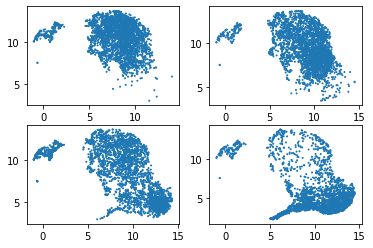

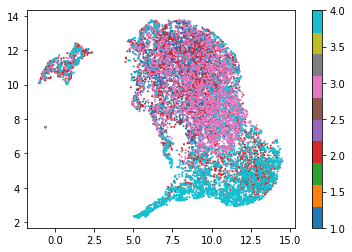

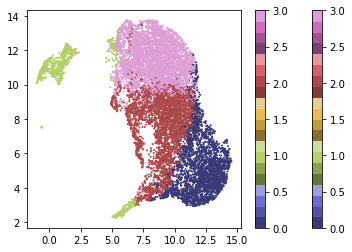

[[0.019      0.079      0.27333333 0.62866667]
 [0.135      0.049      0.40433333 0.41166667]
 [0.324      0.12233333 0.21833333 0.33533333]
 [0.532      0.149      0.24233333 0.07666667]]


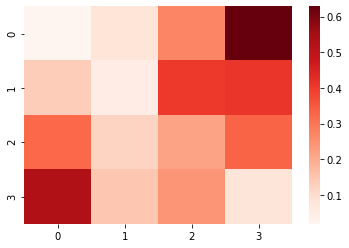

m3U_IVT
-2.833169673976954e-05
m3U
-2.1670030037057586e-06
Y_IVT
-3.4082553611369804e-05
Y
-3.0030738344066776e-05
CGTAA
{'Y', 'm3U_IVT', 'm3U', 'Y_IVT'} 12000


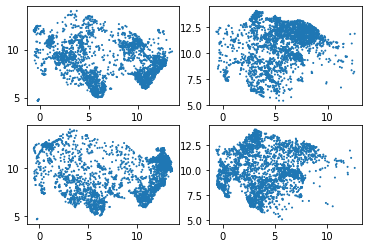

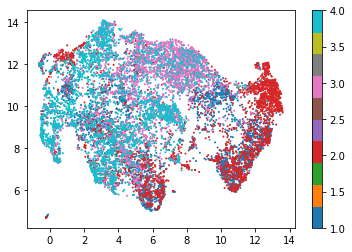

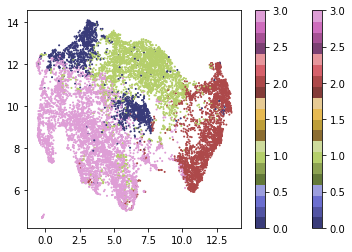

[[0.02366667 0.18933333 0.328      0.459     ]
 [0.16066667 0.55466667 0.015      0.26966667]
 [0.09233333 0.07733333 0.51433333 0.316     ]
 [0.26533333 0.175      0.01233333 0.54733333]]


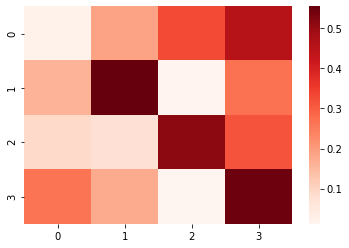

m62A_IVT
-1.7049300367943943e-05
m62A
-8.402118510275614e-06
Am_IVT
-5.770932148152497e-06
Am
3.850198311283748e-07
GGAAC
{'m62A_IVT', 'Am_IVT', 'Am', 'm62A'} 12000


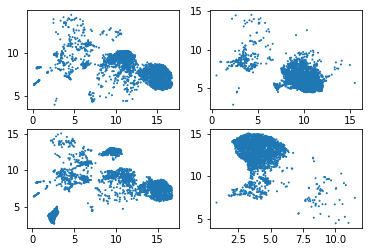

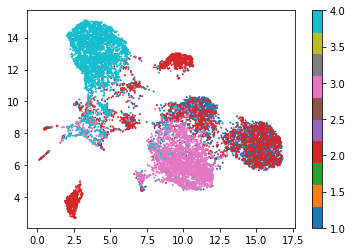

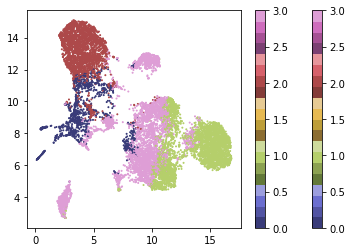

[[0.087      0.60033333 0.04366667 0.269     ]
 [0.08966667 0.33233333 0.00833333 0.56966667]
 [0.097      0.32466667 0.04866667 0.52966667]
 [0.134      0.00266667 0.83666667 0.02666667]]


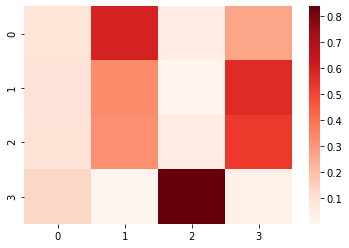

m62A_IVT
-4.851944322581403e-05
m62A
-1.4241056305763777e-05
m26A _IVT
-5.365957349567907e-06
m26A 
-2.417496216366999e-05
GAACC
{'m26A ', 'm62A_IVT', 'm26A _IVT', 'm62A'} 12000


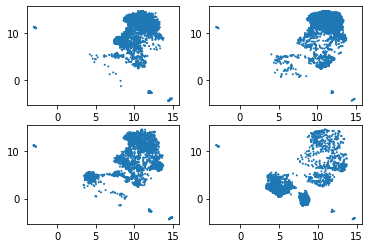

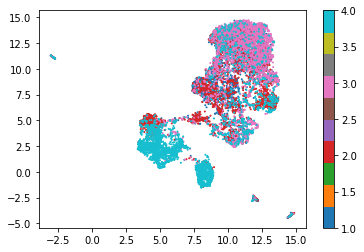

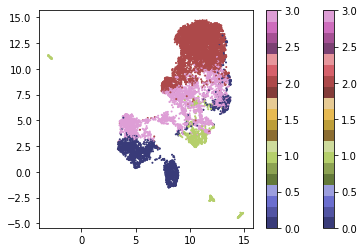

[[0.008      0.08266667 0.65466667 0.25466667]
 [0.032      0.09166667 0.695      0.18133333]
 [0.076      0.076      0.35066667 0.49733333]
 [0.67166667 0.04566667 0.09566667 0.187     ]]


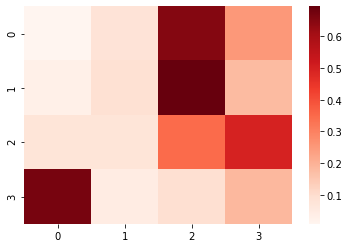

Am_IVT
-4.10696811741218e-05
Am
-2.860026881990052e-07
m1A_IVT
-2.0574601876433007e-05
m1A
-3.2250845833914354e-05
TTAAA
{'m1A_IVT', 'Am_IVT', 'Am', 'm1A'} 12000


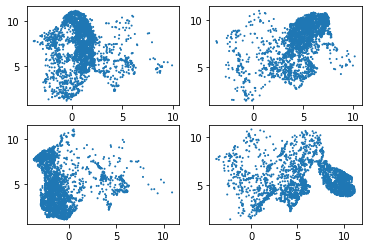

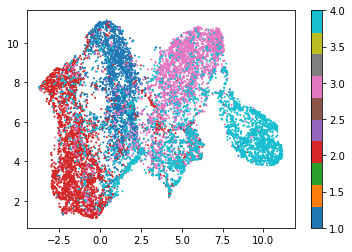

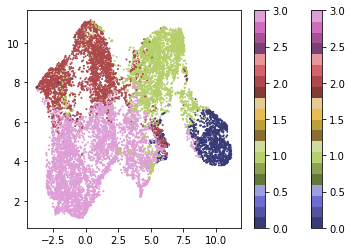

[[0.01133333 0.03533333 0.53066667 0.42266667]
 [0.01833333 0.69833333 0.083      0.20033333]
 [0.011      0.02       0.25033333 0.71866667]
 [0.39266667 0.223      0.08033333 0.304     ]]


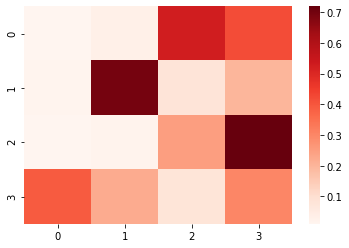

Y_IVT
5.801277893624501e-06
Y
-6.250032583920984e-06
Um_IVT
-3.298857336631045e-05
Um
-4.666339737013914e-05
ACTCT
{'Y', 'Um', 'Um_IVT', 'Y_IVT'} 12000


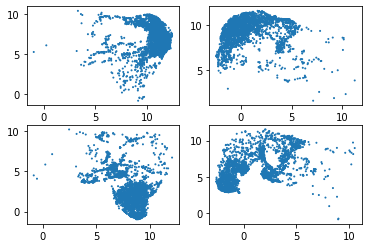

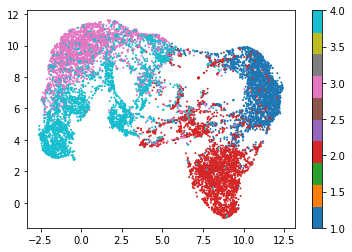

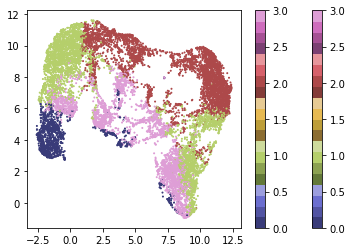

[[0.00233333 0.18766667 0.768      0.042     ]
 [0.02266667 0.597      0.28733333 0.093     ]
 [0.05733333 0.331      0.10533333 0.50633333]
 [0.35933333 0.14066667 0.17366667 0.32633333]]


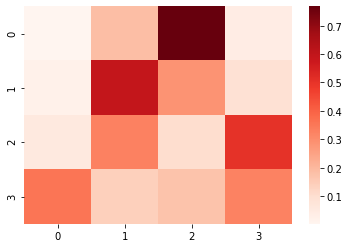

Um/Y/Ym_IVT
-6.321010005194694e-05
Um/Y/Ym
4.827217253478011e-06
m3Y_IVT
-3.722975634445902e-06
m3Y
3.4776319807861e-05
Y_IVT
-3.481129897409119e-05
Y
-3.482519605313428e-05
ACTAT
{'Y_IVT', 'm3Y', 'Y', 'm3Y_IVT', 'Um/Y/Ym', 'Um/Y/Ym_IVT'} 18000


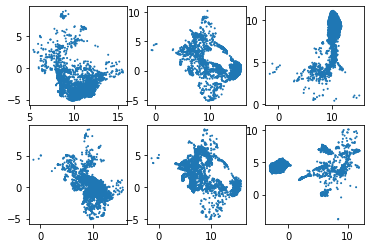

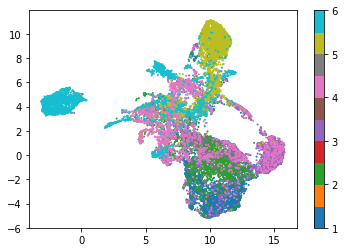

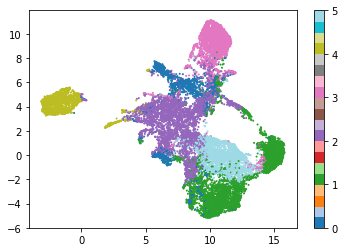

[[0.01766667 0.68866667 0.15866667 0.02       0.         0.115     ]
 [0.08366667 0.47666667 0.20433333 0.05066667 0.002      0.18266667]
 [0.061      0.02933333 0.206      0.69766667 0.005      0.001     ]
 [0.03633333 0.121      0.27733333 0.01833333 0.008      0.539     ]
 [0.22166667 0.15733333 0.47966667 0.02       0.02       0.10133333]
 [0.18766667 0.00266667 0.18766667 0.06466667 0.55533333 0.002     ]]


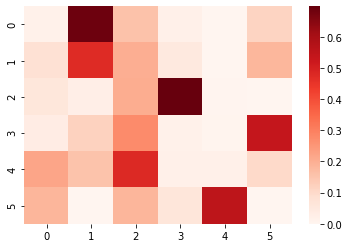

In [4]:
# trim adoptor 
# into Unit size Parquet
import glob
import h5py
import numpy as np
import pyarrow as pa
import tensorflow as tf # add
from pyarrow import parquet as pq
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Dropout, concatenate,\
    BatchNormalization, GaussianNoise, GlobalAveragePooling1D, Softmax
from tensorflow.keras.layers import Conv1D, UpSampling1D , Conv2D
from tensorflow.keras.layers import MaxPooling1D,AveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import  ZeroPadding1D
from tensorflow.keras.layers import Concatenate
import tensorflow.keras
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from statsmodels import robust
import cnn_network_tf
from tensorflow.keras.layers import GlobalAveragePooling1D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv1D, Dense, Dropout, GlobalAveragePooling1D, Input, MaxPooling1D
from tensorflow.keras.regularizers import l2
import copy
import random
from funcy import concat, identity, juxt, partial, rcompose, repeat, take
import matplotlib.pyplot as plt
import seaborn as sns
import faiss

DATA_LENGTH_UNIT = 60
DATA_LENGTH = DATA_LENGTH_UNIT*5+20

import umap.umap_ as umap
from sklearn.datasets import load_digits
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
import time


def getModel(weight_path):

    shape1=(None,  DATA_LENGTH,2)
    num_classes_org = 1024
    with tf.device("/cpu:0"):

        model = build_network(shape=shape1, num_classes=num_classes_org)  
        model._layers.pop() #remove last layer
        model._layers.pop() #remove last layer
        model._layers.pop() #remove last layer
        flat = GlobalAveragePooling1D()(model.layers[-1].output)
        model_t = Model(inputs=model.input,outputs=flat)                    
        model_t.load_weights(weight_path) 
        
#        model_t.summary()
#         model_t._layers.pop() #remove last layer

#         for layer in model_t.layers:
#             layer.trainable = False
        
         
#         x = Conv1D(16, 5, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(model_t.layers[-1].output)
#         x = Conv1D(16, 5, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(x)
#         x = Conv1D(16, 5, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(x)
#         x = BatchNormalization()(x)
#         x = Activation("relu")(x)
#         x = Dense(16, activation="relu")(x)
#         x = Dense(16, activation="relu")(x)
#         x = GlobalAveragePooling1D()(x)
#         Z = Dense(6, activation="softmax")(x)
        
#         x = Conv1D(16, 5, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(model_t.layers[-1].output)
#         x = Conv1D(16, 5, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(x)
#         x = Conv1D(16, 5, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(x)
#         x = BatchNormalization()(x)
#         x = Activation("relu")(x)
#         x = Dense(16, activation="relu")(x)
#         x = Dense(16, activation="relu")(x)
#         x = GlobalAveragePooling1D()(x)
#         overclustering = Dense(20, activation="softmax")(x)
        
#         model_iic =Model(inputs=model.input,outputs=[Z, overclustering])
        
#         model_iic.summary()
        
        
    return model_t  


# def fourtimes(z):
    
    
#     alen = tf.size(z)
#     print(alen)
#     print(z)
#     ar = np.zeros(alen * 4)
#     m = 0
#     for n in range(alen):
        
#         ar[m] = z[n]
#         ar[m+1] = z[n]
#         ar[m+1] = z[n]
#         ar[m+1] = z[n]
#         m = m +4
    
#     ar = tf.convert_to_tensor(ar, dtype=tf.float32)
#     return ar
    

def IIC(z, z_, c=6):
    
    z = tf.reshape(z, [-1, c, 1])
    z_ = tf.reshape(z_, [-1, 1, c])
    P = tf.math.reduce_sum(z * z_, axis=0)  # 同時確率
    P = (P + tf.transpose(P)) / 2  # 対称化
    P = tf.clip_by_value(P, 1e-7, tf.float32.max)  # logが発散しないようにバイアス
    P = P / tf.math.reduce_sum(P)  # 規格化

    # 周辺確率
    Pi = tf.math.reduce_sum(P, axis=0)
    Pi = tf.reshape(Pi, [c, 1])
    Pi = tf.tile(Pi, [1,c])
    Pj = tf.math.reduce_sum(P, axis=1)
    Pj = tf.reshape(Pj, [1, c])
    Pj = tf.tile(Pj, [c,1])

    #loss = tf.math.reduce_sum(P * (tf.math.log(Pi) + tf.math.log(Pj) - tf.math.log(P)))
    alpha = 10
    loss = tf.math.reduce_sum(P * (alpha * tf.math.log(Pi) + alpha * tf.math.log(Pj) - tf.math.log(P)))
    
    return loss



def toDataSet(df):
    
    data = []
    modflg = 0
    for idx, row in df.iterrows():
        
        iVTdata = np.array(row[6]).astype(float)        
        iVTdata = np.reshape(iVTdata, (-1, DATA_LENGTH*2,))
            
     
        modflg = modflg + 1
        mod = row[1]+"_IVT"
        
        for m in range(0,len(iVTdata)):
            
            sig = iVTdata[m]
            if m == 0:
                print(mod)
                print(sig[0])
            tp = (modflg,mod,sig)
            data.append(tp)
            
    
        nativedata = np.array(row[7]).astype(float)   
        nativedata = np.reshape(nativedata, (-1, DATA_LENGTH*2,))
        

        modflg = modflg + 1
        mod = row[1]
        
        for n in range(0,len(nativedata)):
            
            
            sig = nativedata[n]
            if n == 0:
                print(mod)
                print(sig[0])
            
            tp = (modflg,mod,sig)
            data.append(tp)
        
        
        
    return data 
    

def getSuffledBatch(dataset,batchsize):
    
    ret = []
    random.shuffle(dataset)
    n = 0
    while n <= len(dataset):
        
        batchX = []
        batchX_ = []
        if n < len(dataset):
            
            for m in range(batchsize):

                modflg,mod,sig = dataset[n]
                #4 times
                batchX.extend(sig)
                batchX.extend(sig)
                batchX.extend(sig)
                batchX.extend(sig)
                
                batchX_.extend(sigg)

                n = n+1
                if n >= len(dataset)-1:
                    break
        else:
            break
        
        if len(batchX) > 0:            
            
            batchX = np.array(batchX ,dtype=np.float32)
            batchX = np.reshape(batchX, (-1, DATA_LENGTH,2))
            batchX_ = np.array(batchX_ ,dtype=np.float32)
            batchX_ = np.reshape(batchX_, (-1, DATA_LENGTH,2))
            
            ret.append((batchX,batchX_))   
    
    return ret


def getOriginalDataAndLabel(dataset):

    batchX = []
    flg = []
    s = set()
    cnt = 0
    for n in range(len(dataset)):
        
        modflg,mod,sig = dataset[n]
        batchX.extend(sig)
        flg.append(modflg)
        s.add(mod)
        cnt = cnt +1
    
    batchX = np.array(batchX,dtype=np.float32)
    batchX = np.reshape(batchX, (-1, DATA_LENGTH,2))
    flg = np.array(flg)    
    print(s,cnt)
    
    return flg,batchX
        

batchsize = 256
epoch_num = 10
#ICC
def mainflow():
    
    wfile = "/groups2/gac50430/nanopore/dataset4DL/weight5merm6A/"
    
    fmers =["CGCCC","CGTAA","GGAAC","GAACC","TTAAA","ACTCT"]
    
    for fmer in fmers:
    
        pqf = "/groups2/gac50430/nanopore/shell/nanoIICTest/"+fmer+"_org.pq"
        table = pq.read_table(pqf)
        df = table.to_pandas()

        dataset = toDataSet(df)

        #parepare data

        weight_path = wfile+fmer+"/model_t_ep_1.h5"
        model = getModel(weight_path)
        print(fmer)

        flgs,Xorg = getOriginalDataAndLabel(dataset)

        x = model.predict(Xorg)
        embedding = umap.UMAP().fit_transform(x)

        fig = plt.figure()
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 3)
        ax3 = fig.add_subplot(2, 2, 2)
        ax4 = fig.add_subplot(2, 2, 4)
        
        e1 = embedding[0:3000]
        ax1.scatter(e1[:,0],e1[:,1],c=flgs[0:3000],cmap=cm.tab10,s=1)

        e2 = embedding[3000:6000]
        ax2.scatter(e2[:,0],e2[:,1],c=flgs[3000:6000],cmap=cm.tab10,s=1)
        
        e3 = embedding[6000:9000]
        ax3.scatter(e3[:,0],e3[:,1],c=flgs[6000:9000],cmap=cm.tab10,s=1)
        
        e4 = embedding[9000:12000]
        ax4.scatter(e4[:,0],e4[:,1],c=flgs[9000:12000],cmap=cm.tab10,s=1)
        
        
        plt.plot()
        plt.savefig( fmer+"all.png", format="png", dpi=300)
        plt.show()

        
        plt.scatter(embedding[:,0],embedding[:,1],c=flgs,cmap=cm.tab10,s=1)
        plt.colorbar()
        plt.savefig( fmer+".png", format="png", dpi=300)
        plt.show()
        
        #clustering
        ncentroids = 4
        niter = 500
        verbose = True
        d = x.shape[1]
        kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
        kmeans.train(x)
        
        D, I = kmeans.index.search(x, 1)

        plt.scatter(embedding[:,0],embedding[:,1],c=I,cmap=cm.tab20b,s=1)
        plt.colorbar()
        plt.savefig( fmer+"_cluster.png", format="png", dpi=300)
        plt.colorbar()
        plt.show()
        
        
        counter = {}
        for n in range(4):
            counter[n] = np.zeros(4)

        n = 0
        for fg in flgs:
            cn = counter[fg-1]
            idx = I[n]
            cn[idx] = cn[idx]+1
            n = n+1

        data = []    
        data.append(counter[0])
        data.append(counter[2])
        data.append(counter[1])
        data.append(counter[3])
            

        
        data = np.array(data)
        data = data/3000
        print(data)
        sns.heatmap(data,cmap="Reds")
        plt.plot()
        plt.show()
        
    
#     ncentroids = 3
#     niter = 10
#     verbose = True
#     d = x.shape[1]
#     kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
#     kmeans.train(x)
    
#     D, I = kmeans.index.search(x, 1)
    
#     print(D)
#     print(I)
    
def mainflow2():
    
    wfile = "/groups2/gac50430/nanopore/dataset4DL/weight5merm6A/"
    
    fmers =["ACTAT"]
    
    for fmer in fmers:
    
        pqf = "/groups2/gac50430/nanopore/shell/nanoIICTest/"+fmer+"_org.pq"
        table = pq.read_table(pqf)
        df = table.to_pandas()

        dataset = toDataSet(df)

        #parepare data

        weight_path = wfile+fmer+"/model_t_ep_1.h5"
        model = getModel(weight_path)
        print(fmer)

        flgs,Xorg = getOriginalDataAndLabel(dataset)

        x = model.predict(Xorg)
        embedding = umap.UMAP().fit_transform(x)

        fig = plt.figure()
        ax1 = fig.add_subplot(2, 3, 1)
        ax2 = fig.add_subplot(2, 3, 4)
        ax3 = fig.add_subplot(2, 3, 2)
        ax4 = fig.add_subplot(2, 3, 5)
        ax5 = fig.add_subplot(2, 3, 3)
        ax6 = fig.add_subplot(2, 3, 6)
        
        e1 = embedding[0:3000]
        ax1.scatter(e1[:,0],e1[:,1],c=flgs[0:3000],cmap=cm.tab10,s=1)

        e2 = embedding[3000:6000]
        ax2.scatter(e2[:,0],e2[:,1],c=flgs[3000:6000],cmap=cm.tab10,s=1)
        
        e3 = embedding[6000:9000]
        ax3.scatter(e3[:,0],e3[:,1],c=flgs[6000:9000],cmap=cm.tab10,s=1)
        
        e4 = embedding[9000:12000]
        ax4.scatter(e4[:,0],e4[:,1],c=flgs[9000:12000],cmap=cm.tab10,s=1)

        e5 = embedding[12000:15000]
        ax5.scatter(e5[:,0],e5[:,1],c=flgs[12000:15000],cmap=cm.tab10,s=1)
        
        e6 = embedding[15000:18000]
        ax6.scatter(e6[:,0],e6[:,1],c=flgs[15000:18000],cmap=cm.tab10,s=1)
        
        plt.plot()
        plt.savefig( fmer+"all.png", format="png", dpi=300)
        plt.show()

        
        plt.scatter(embedding[:,0],embedding[:,1],c=flgs,cmap=cm.tab10,s=1)
        plt.colorbar()
        plt.savefig( fmer+".png", format="png", dpi=300)
        plt.show()
        
         #clustering
        ncentroids = 6
        niter = 500
        verbose = True
        d = x.shape[1]
        kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
        kmeans.train(x)
        
        D, I = kmeans.index.search(x, 1)

        plt.scatter(embedding[:,0],embedding[:,1],c=I,cmap=cm.tab20,s=1)
        plt.colorbar()
        plt.savefig( fmer+"_cluster.png", format="png", dpi=300)
        plt.show()


        counter = {}
        for n in range(6):
            counter[n] = np.zeros(6)

        n = 0
        for fg in flgs:
            cn = counter[fg-1]
            idx = I[n]
            cn[idx] = cn[idx]+1
            n = n+1

        data = []    
        data.append(counter[0])
        data.append(counter[2])
        data.append(counter[4])
        data.append(counter[1])
        data.append(counter[3])
        data.append(counter[5])
            

        data = np.array(data)
        data = data/3000
        print(data)
        sns.heatmap(data,cmap="Reds")
        plt.plot()
        plt.show()
        
        
     
def build_network(shape,num_classes):
    
    # Utility functions.
    
    def ljuxt(*fs): 
        return rcompose(juxt(*fs), list)

    def conv1D(filters, kernel_size):
        return Conv1D(filters, kernel_size, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))  
    
    def conv1D_halve(filters, kernel_size):
        return Conv1D(filters, kernel_size, padding='same',strides=2, kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)) 

    def dense(units, activation):
        return Dense(units, activation=activation, kernel_regularizer=l2(0.0001))
      
 
    # Define SqueezeNet.
    def fire_module(filters_squeeze, filters_expand):
        return rcompose(BatchNormalization(),
                        Activation('relu'),
                        conv1D(filters_squeeze, 1),
                        BatchNormalization(),
                        Activation('relu'),
                        ljuxt(conv1D(filters_expand // 2, 1),
                              conv1D(filters_expand // 2, 3)),
                        Concatenate())
     

    def fire_module_with_shortcut(filters_squeeze, filters_expand):
        return rcompose(ljuxt(fire_module(filters_squeeze, filters_expand),
                              identity),
                        Add())
    
    

    # Inception　Module.
    def inception():
        
        u1 = rcompose(AveragePooling1D(pool_size=3, strides=1, padding='same'),
                      conv1D(48, 1))
        u2 = conv1D(48, 1)
        u3 = rcompose(conv1D(16, 1),
                      conv1D(48, 3))
        u4 = rcompose(conv1D(16, 1),
                      conv1D(48, 3),
                      conv1D(48, 3))
        
        return rcompose(ljuxt(u1,u2,u3,u4),
                        Concatenate(axis=2))

    
    def convBlock(f1, k1,f2, k2,f3, k3,do_r):
        return rcompose(conv1D(f1, k1),
                    conv1D(f2, k2),
                    conv1D(f3, k3),
                    MaxPooling1D(pool_size=2),
                    BatchNormalization(),
                    Dropout(do_r))
   
    
    do_r = 0.30
    #x = inputs    
    input = Input(batch_shape=shape)
    nnBlock = rcompose(GaussianNoise(stddev=0.005) ,                    
                    conv1D_halve(32, 3),
                    BatchNormalization(),
                    Dropout(do_r), 
                    convBlock(48,3,48,3,48,3,do_r),   
                    convBlock(16,1,32,3,32,3,do_r),     
                    fire_module(8, 32),
                    fire_module_with_shortcut(8, 32),
                    fire_module(16, 64),   
                    MaxPooling1D(),
                    fire_module_with_shortcut(16, 64),
                    BatchNormalization(),
                    Dropout(do_r),
                    Activation('relu'),
                    conv1D(16, 3),   
                    conv1D_halve(16, 3), 
                    convBlock(16,3,16,1,16,3,do_r),     
                    conv1D(num_classes,1),
                    GlobalAveragePooling1D(),
                    Activation('softmax'))
    
    return Model(inputs=input, outputs=nnBlock(input)) 


if __name__ == '__main__':
    
    import sys
    sys.path.append("/usr/local/lib/python3.5/dist-packages/")
    mainflow()
    mainflow2()

In [4]:
!pip3 uninstall umap

In [11]:
!y

/bin/sh: y: command not found
